# Итоговый проект: телекоммуникации

# Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно; 
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic).

Дополнительные услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Цель проекта** 

Обучить модель машинного обучения, прогнозирующую возможный отток клиентов.

**Задачи проекта**
- загрузить данные
- подготовить итоговую таблицу, которая будет включать в себя всех клиентов
- провести исследовательский и корреляционный анализы
- подготовить и обучить разные модели
- выбрать лучшую модель
- провести анализ и интерпретацию важности признаков

**Целевое ограничение** 

Значение метрики roc_auc лучшей модели на тестовой выборке должно быть >= 0.85.

## Подготовка

Загружаем необходимые библиотеки.

In [1]:
!pip install pandas -q
!pip install matplotlib -q
!pip install phik -q
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.3.2

Found existing installation: scikit-learn 0.24.1
Uninstalling scikit-learn-0.24.1:
  Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 10.9 MB 2.0 MB/s eta 0:00:01 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 89.8 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [2]:
import pandas as pd
import warnings
warnings.simplefilter("ignore") 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import sklearn
import phik
from datetime import (datetime as dt, 
                      date, 
                      time)
from functools import reduce
from phik.report import plot_correlation_matrix

from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     RandomizedSearchCV,
                                     cross_val_score)
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   PolynomialFeatures, 
                                   RobustScaler,
                                   LabelEncoder)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, 
                             accuracy_score, 
                             confusion_matrix, 
                             mean_squared_error, 
                             mean_absolute_error, 
                             r2_score,
                             make_scorer,
                             RocCurveDisplay)
from catboost import CatBoostClassifier

Вводим константы.

In [3]:
RANDOM_STATE = 80925
TEST_SIZE = 0.25

## Загрузка данных

Создадим датасеты и укажем в них наши данные.

In [4]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

Выведем первые строки и информацию, чтобы проверить содержание наших данных.

In [5]:
display(contract.head())
print(contract.info())
print()
display(personal.head())
print(personal.info())
print()
display(internet.head())
print(internet.info())
display(phone.head())
print(phone.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


**Выводы по загрузке данных**

- Данные были загружены и проверены на соответствие
- Некоторые числа и даты записаны типом object (требуется заменить)
- Булевые переменные обозначены словами (не требует изменений)
- Отсутствуют пропуски в данных
- Отсутствует столбец с целевым признаком (требуется создать) 

## Предобработка данных

Изменим тип данных там, где это необходимо.

In [6]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

Создадим столбец с целевым признаком, опираясь на данные из столбца EndDate. Для этого посмотрим на уникальные значения столбца.

In [7]:
print(contract['EndDate'].unique())

['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' '2014-12-01'
 '2014-11-01']


Можно выделить два вида данных: дата завершения договора и **No**, если договор не был завершен. ИСходя из этого мы можем создать столбец с целевым признаком **target**, где 1 означает незавершенный контракт (No), а 0 - завершенный контракт.

In [8]:
contract['target'] = [1 if i != 'No' else 0 for i in contract['EndDate']]

Проверим столбец с целевым признаком.

In [9]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


Чтобы изменить привести тип данных к datetime в столбце EndDate изменим значение No на дату, когда были представлены данные - 1 февраля 2020 года.

In [10]:
contract.loc[(contract['EndDate'] == 'No'),'EndDate'] = '2020-02-01'

Изменим тип данных в столбце EndDate на datetime.

In [11]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'],format= "%Y/%m/%d")

Теперь, когда данные преведены к подходящим типам, проверим датасеты на наличие дубликатов.

In [12]:
print(contract.duplicated().sum())
print(personal.duplicated().sum())
print(internet.duplicated().sum())
phone.duplicated().sum()

0
0
0


0

Выведем информацию по уникальным наименованиям текстовых столбцов во всех датафреймах чтобы проверить названия на опечатки.

In [13]:
unique_values = contract['Type'].unique()
print(unique_values)
unique_values = contract['PaymentMethod'].unique()
print(unique_values)
unique_values = personal['gender'].unique()
print(unique_values)
unique_values = internet['InternetService'].unique()
print(unique_values)

['Month-to-month' 'One year' 'Two year']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
['Female' 'Male']
['DSL' 'Fiber optic']


Опечаток не обнаружено. Вывдеме всю информацию о датасетах ещё раз, чтобы проверить изменения.

In [14]:
display(contract.head())
print(contract.info())
print()
display(personal.head())
print(personal.info())
print()
display(internet.head())
print(internet.info())
display(phone.head())
print(phone.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB
None



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


**Выводы по предобработке данных**

- Числа и даты были переведены в нужный тип данных
- Создан столбец с целевым признаком
- Дубликаты не обнаружены
- Опечатки не обнаружены

## Исследовательский анализ данных

Для исследовательского анализа данных обьединим все датафреймы по столбцу **customerID** для более удобной дальнейшней работы.

In [15]:
names = [contract, internet, personal, phone]
data = reduce(lambda left,right: pd.merge(left, right, on=['customerID'], how='outer'), names)

In [16]:
display(data.head())
print()
data.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,DSL,...,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,DSL,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,DSL,...,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,DSL,...,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Fiber optic,...,No,No,No,No,No,Female,0,No,No,No



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7043 non-null   int64         
 9   InternetService   5517 non-null   object        
 10  OnlineSecurity    5517 non-null   object        
 11  OnlineBackup      5517 non-null   object        
 12  DeviceProtection  5517 non-null   object        
 13  TechSupport       5517 non-null   object        
 14  StreamingTV       5517 

После объединения появились пропуски в данных.

In [17]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
target                 0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

Мы видим несколько столбцов с одинаковым количеством пропусков. Разберемся с ними поотдельности. 

Столбцы со значением пропусков 1526 - это пользователи, о которых не было никакой информации в датафрейме **Internet**. Скорее всего они просто не подключили данную услугу. 

Пропуски в столбце **MyltiplieLines** говорят что пользователь не пользовался услугами телефона. 

Заменим эти пропуски на фразы **no_internet** и **no_phone**.

In [18]:
data['MultipleLines'].fillna('no_phone', inplace = True)

internet_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for column in internet_columns:
    data[column].fillna('no_internet', inplace=True)

In [19]:
data.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
target               0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
MultipleLines        0
dtype: int64

Отдельно рассмотрим пропуски в столбце **TotalCharges**.

In [20]:
data[data['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,DSL,...,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,no_phone
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,no_internet,...,no_internet,no_internet,no_internet,no_internet,no_internet,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,DSL,...,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,no_internet,...,no_internet,no_internet,no_internet,no_internet,no_internet,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,DSL,...,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,no_phone
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,no_internet,...,no_internet,no_internet,no_internet,no_internet,no_internet,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,no_internet,...,no_internet,no_internet,no_internet,no_internet,no_internet,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,no_internet,...,no_internet,no_internet,no_internet,no_internet,no_internet,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,no_internet,...,no_internet,no_internet,no_internet,no_internet,no_internet,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,DSL,...,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


Даты в столбцах **BeginDate** и **EndDate** совпадают. Из этого можно сделать вывод, что данные абоненты еще не успели оплатить услуги, так как заключили договор в день сбора данных. Заполним пропуски ежемесячным платежом **MonthlyCharges**.

In [21]:
data['TotalCharges'].fillna(data[data['TotalCharges'].isnull()]['MonthlyCharges'], inplace = True)

Создадим новый столбец **period** с количеством дней, которые пользователи пользуются подпиской.

In [22]:
data['period']=(data['EndDate']-data['BeginDate'])/np.timedelta64(1,'D')

Проверим все изменения.

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
 9   InternetService   7043 non-null   object        
 10  OnlineSecurity    7043 non-null   object        
 11  OnlineBackup      7043 non-null   object        
 12  DeviceProtection  7043 non-null   object        
 13  TechSupport       7043 non-null   object        
 14  StreamingTV       7043 n

После того, как все пропуски были заполнены, можно приступить к визуализации данных.

Создадим гистограммы для численных данных и круговые диаграммы для категориальных.

Гистаграммы для всех числовых переменных:



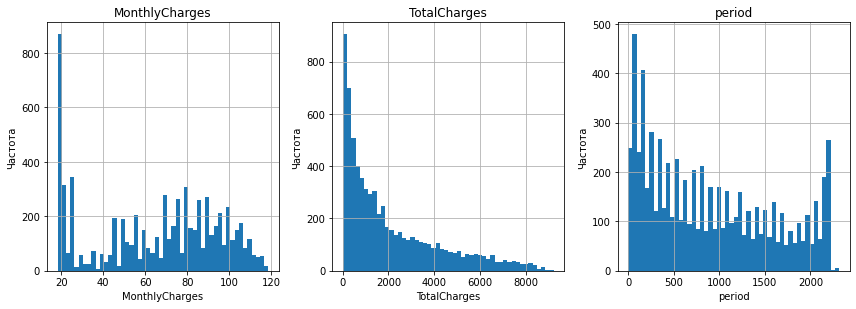

In [24]:
print('Гистаграммы для всех числовых переменных:\n')

# Найдем числовые столбцы в датафрейме
numerical_columns = ['MonthlyCharges', 'TotalCharges','period']

# Зададим размер фигуры для удобства визуализации
plt.figure(figsize=(12, 8))

# Цикл для итерации по каждому числовому столбцу
for i, column in enumerate(numerical_columns):
    # Создаем subplot для текущего столбца
    plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, текущий график
    
    # Строим гистограмму для текущего столбца
    data[column].hist(bins=50)
    
    # Добавляем заголовок с названием столбца
    plt.title(column)
    
    # Добавляем метки для осей
    plt.xlabel(column)
    plt.ylabel('Частота')

# Отображаем все гистограммы
plt.tight_layout()
plt.show()

Круговые диаграммы для всех категориальных переменных:



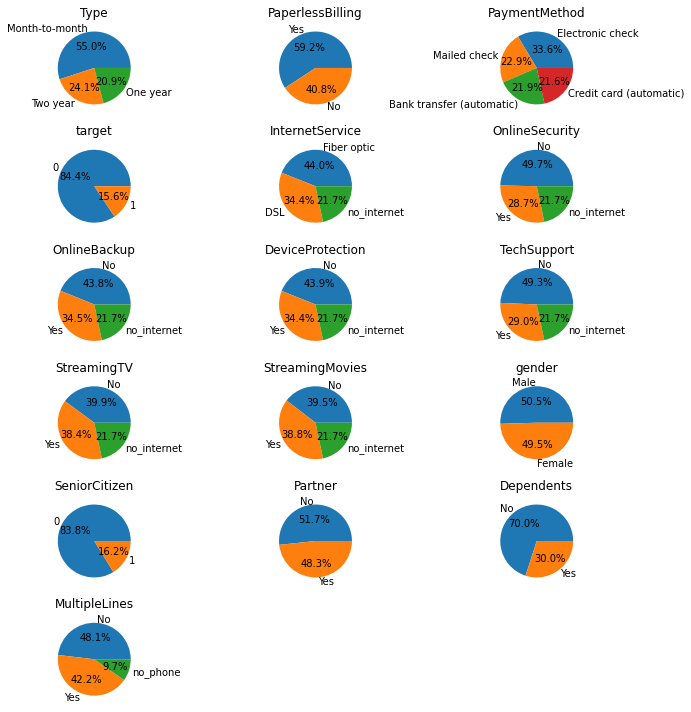

In [25]:
print('Круговые диаграммы для всех категориальных переменных:\n')

# Список столбцов, для которых нужно вывести круговые диаграммы
categorical_columns = [col for col in data.columns if col not in numerical_columns and col != 'BeginDate' and col != 'customerID' and col != 'EndDate']

# Зададим размер фигуры для удобства визуализации
plt.figure(figsize=(10, 10))

# Цикл для итерации по каждому столбцу
for i, column in enumerate(categorical_columns):
    # Создаем subplot для текущего столбца
    plt.subplot(6, 3, i + 1)  # 3 строки, 2 столбца, текущий график
    
    # Подсчитываем количество каждого уникального значения в текущем столбце
    column_data = data[column].value_counts()
    
    # Строим круговую диаграмму для текущего столбца
    plt.pie(column_data, labels=column_data.index, autopct='%1.1f%%')
    
    # Добавляем заголовок с названием столбца
    plt.title(column)

# Отображаем все круговые диаграммы
plt.tight_layout()
plt.show()

**Выводы по исследовательскому анализу данных**

- В данных выбросов не обнаружено.
- Месячные оплаты распределены таким образом, что основная часть пользователей платят 20 долларов, видимо, это цена минимальной подписки.
- Дальше помесячная оплата распределена более равномерно с пиками сумм 50, 60, 70, 80, 90, 100 и 110 долларов.
- В гистограмме **period** мы видим, что новых пользователей, которые пользуются подпиской первый год, больше. Однако есть и достаточно большое количесво пользователей, которые пользуются подпиской более 5 с половиной лет.
- Чуть больше половины пользователей предпочитаю **помесячную оплату** подписки.
- У 21% пользователей не подключена дополнительная услуга интернета.
- Количество пользователей мужчин и женщин практически одинаковое. 
- 16% пользователей - это жители пенсионного возраста.
- **15% процентов пользователей не продлили подписку**.

## Корреляционный анализ данных

Проведем корреляционный анализ всех признаков в датасете и отберем те, которые влияют на целевую переменную.

Сначала сделаем копию данных и уберем столбец **customerID**, **EndDate** (так как на основе этого столбца формировали target) и **BeginDate** (так как на основе этого столбца формировали period).

In [26]:
data_corr = data.copy()
data_corr = data_corr.drop(columns=['customerID', 'EndDate', 'BeginDate'])

Построим матрицу корреляции phik.

In [27]:
phik_overview = data_corr.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'SeniorCitizen', 'period']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,period
Type,1.00,0.11,0.28,0.39,0.47,0.09,0.51,0.64,0.58,0.63,0.67,0.55,0.55,0.00,0.09,0.18,0.15,0.24,0.63
PaperlessBilling,0.11,1.00,0.37,0.47,0.20,0.08,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.00,0.24,0.01,0.17,0.10,0.03
PaymentMethod,0.28,0.37,1.00,0.40,0.34,0.21,0.32,0.32,0.29,0.30,0.32,0.28,0.29,0.00,0.29,0.24,0.22,0.17,0.35
MonthlyCharges,0.39,0.47,0.40,1.00,0.71,0.23,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.01,0.30,0.20,0.18,0.71,0.39
TotalCharges,0.47,0.20,0.34,0.71,1.00,0.30,0.49,0.52,0.55,0.56,0.53,0.56,0.55,0.00,0.14,0.38,0.08,0.47,0.85
target,0.09,0.08,0.21,0.23,0.30,1.00,0.06,0.06,0.09,0.09,0.05,0.08,0.09,0.01,0.09,0.23,0.05,0.11,0.37
InternetService,0.51,0.23,0.32,0.92,0.49,0.06,1.00,0.95,0.94,0.94,0.95,0.95,0.95,0.00,0.16,0.00,0.11,0.74,0.06
OnlineSecurity,0.64,0.21,0.32,0.81,0.52,0.06,0.95,1.00,0.95,0.95,0.95,0.94,0.94,0.00,0.13,0.09,0.12,0.54,0.35
OnlineBackup,0.58,0.20,0.29,0.82,0.55,0.09,0.94,0.95,1.00,0.95,0.95,0.95,0.95,0.00,0.11,0.09,0.10,0.56,0.37
DeviceProtection,0.63,0.20,0.30,0.83,0.56,0.09,0.94,0.95,0.95,1.00,0.95,0.95,0.95,0.00,0.11,0.10,0.09,0.56,0.37


In [28]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'period']

phik_overview = data_corr.phik_matrix(interval_cols = interval_cols)

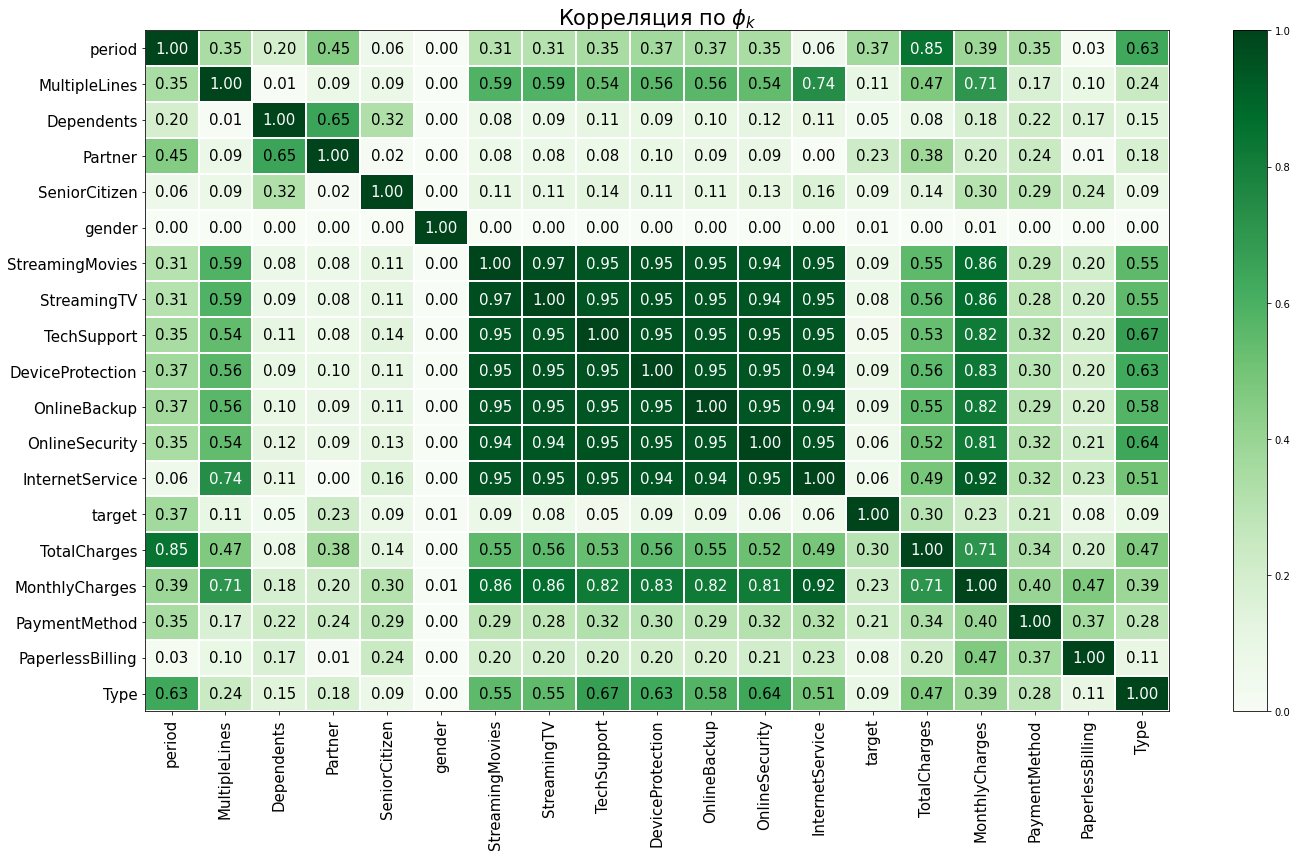

In [29]:
plot_correlation_matrix(phik_overview.values, 
                       x_labels = phik_overview.columns,
                       y_labels = phik_overview.index,
                       vmin = 0,
                       vmax = 1,
                       title = r'Корреляция по $\phi_k$',
                       color_map= "Greens",
                       fontsize_factor = 1.5,
                       figsize = (20, 12))
plt.show();

Мы более отчетливо видим, какие признаки влияют на целевую переменную. Однако очень много признаков, которые имеют слабую корреляцию с **target**.

В датафрейм для обучения модели отберем только те, в которых корреляция больше 0.1.

In [30]:
data1 = data_corr.drop(columns=['Dependents','SeniorCitizen','gender', 'StreamingMovies', 'StreamingTV','TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'InternetService', 'PaperlessBilling', 'Type'])

In [31]:
data1.head()

,PaymentMethod,MonthlyCharges,TotalCharges,target,Partner,MultipleLines,period
0,Electronic check,29.85,31.04,0,Yes,no_phone,31.0
1,Mailed check,56.95,2071.84,0,No,No,1036.0
2,Mailed check,53.85,226.17,0,No,No,123.0
3,Bank transfer (automatic),42.30,1960.60,0,No,no_phone,1371.0
4,Electronic check,70.70,353.50,0,No,No,153.0


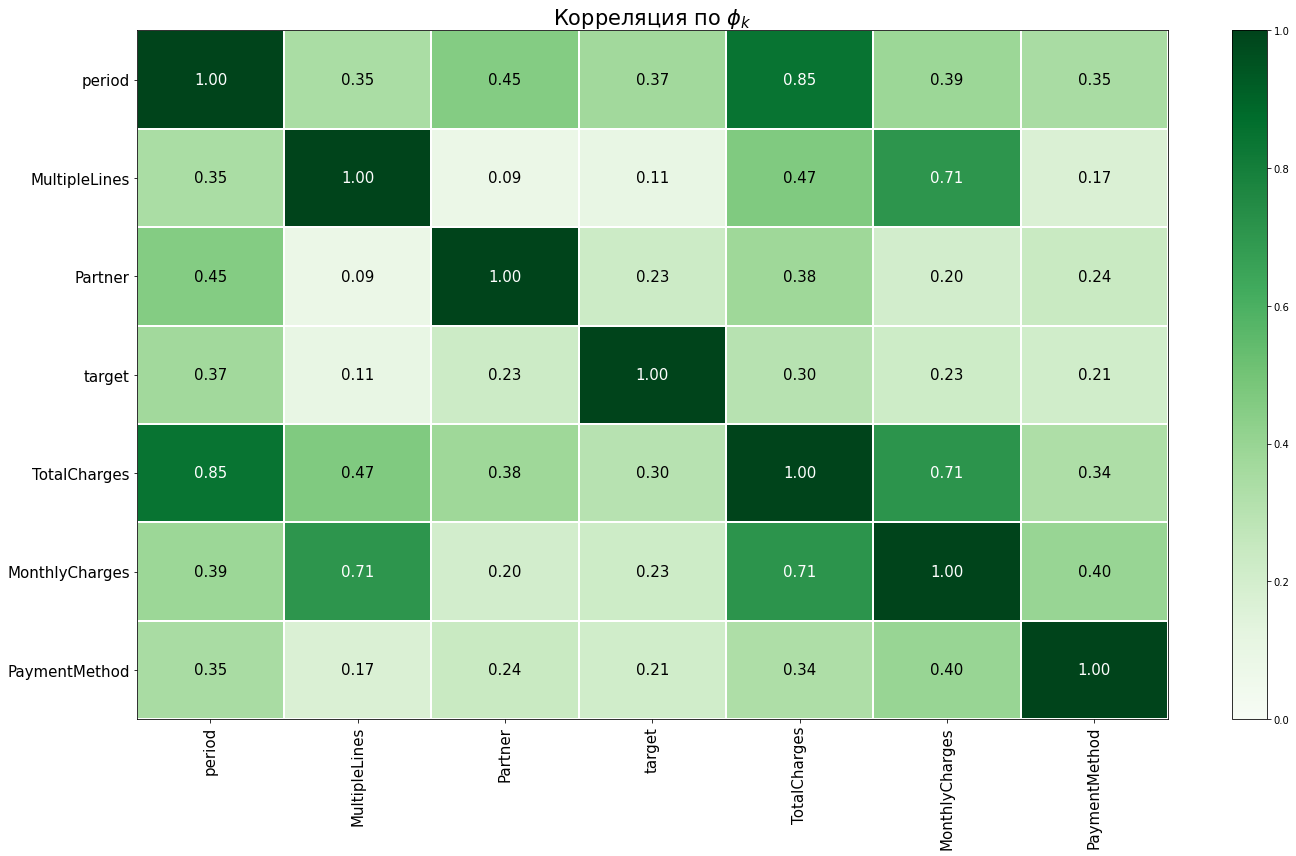

In [32]:
phik_overview = data1.phik_matrix(interval_cols = interval_cols)
plot_correlation_matrix(phik_overview.values, 
                       x_labels = phik_overview.columns,
                       y_labels = phik_overview.index,
                       vmin = 0,
                       vmax = 1,
                       title = r'Корреляция по $\phi_k$',
                       color_map= "Greens",
                       fontsize_factor = 1.5,
                       figsize = (20, 12))
plt.show();

Мы удалили те признаки, которые оказывали меньше всего влияния и оставили более значимые, учитывая корреляцию с целевым признаком. Наибольшие значения показывают:
- сроки использования подписки - **period**.
- сколько клиент потратил на подписку - **TotalCharges**.

Чем дольше клиент пользуется подпиской и чем больше он заплатил за всё время, тем меньше вероятность, что клиент откажется от продления подписки.

## Подготовка и обучение модели

Выделим из датасета data1 целевой признак.

In [33]:
X = data1.drop('target', axis = 1)
y = data1['target']

Выведем размеры датасетов.

In [34]:
X.shape, y.shape

((7043, 6), (7043,))

Сформируем обучающую и тестовые выборки.

In [35]:
X_train, X_test, \
y_train, y_test = train_test_split(
    X, y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y)

Проверим распределение классов.

In [36]:
print('Расспределение в тренировочной выборке:', y_train.value_counts(normalize = True))
print()
print('Расспределение в тестовой выборке:', y_test.value_counts(normalize = True))

Расспределение в тренировочной выборке: 0    0.84362
1    0.15638
Name: target, dtype: float64

Расспределение в тестовой выборке: 0    0.843839
1    0.156161
Name: target, dtype: float64


Создадим списки для кодирования.

In [37]:
num_columns = X_train.select_dtypes(include=['float64','int64']).columns.tolist()
num_columns

['MonthlyCharges', 'TotalCharges', 'period']

In [38]:
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()
for column in cat_columns:
        unique_values = X_train[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")

Уникальные значения для столбца 'PaymentMethod': ['Credit card (automatic)' 'Mailed check' 'Electronic check'
 'Bank transfer (automatic)']
Уникальные значения для столбца 'Partner': ['No' 'Yes']
Уникальные значения для столбца 'MultipleLines': ['No' 'Yes' 'no_phone']


In [39]:
# признаки для OneHotEncoder
ohe_columns = ['PaymentMethod', 'Partner', 'MultipleLines']

# численные признаки
num_columns = ['MonthlyCharges', 'TotalCharges', 'period']

Создадим пайплайн для подготовки признаков из списка ohe_columns.

In [40]:
ohe_pipe = Pipeline([
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (    'ohe', 
            OneHotEncoder(sparse_output=False, handle_unknown='error',drop='first')
        )
])

Создадим общий пайплайн для подготовки данных.

In [41]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)   
    ], 
    remainder =  'passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['PaymentMethod', 'Partner', 'MultipleLines']),
                                ('num', MinMaxScaler(),
                                 ['MonthlyCharges', 'TotalCharges', 'period'])])


Создадим итоговый пайплайн.

In [42]:
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

Визуализируем его.

In [43]:
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['PaymentMethod', 'Partner',
                                                   'MultipleLines']),
                                                 ('num', MinMaxScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'period'])])),
                ('models', DecisionTreeRegressor(random_state=80925))])

Создадим словари для разных моделей: DecisionTreeClassifier, SVC, LogisticRegression.

In [44]:
param_distributions = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__min_samples_split': range(2,20) ,
        'models__min_samples_leaf': range(2,20) ,
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability = True)],
        'models__kernel':('rbf','linear','poly'),
        'models__C': range(1,100),
        'models__degree': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__solver': ('liblinear', 'saga', 'lbfgs'),
        'models__penalty': ('l1', 'l2', 'elasticnet', 'none'),
        'models__C': range(1,100),
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }

] 

In [45]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
    
)

In [46]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train

array([0, 0, 0, ..., 1, 0, 1])

Обучим модель на тренировочной выборке.

In [47]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['PaymentMethod',
                                                                                'Partner',
                                                                                'MultipleLines']),
                                                                              ('num',
                                                                               MinMaxScaler(),
                                                                               ['MonthlyCharges',...
                                                            'poly'),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=80925)],
                                         'models__C': range(1, 100),
                                         'models__penalty': ('l1', 'l2',
                                                             'elasticnet',
                                                             'none'),
                                         'models__solver': ('liblinear', 'saga',
                                                            'lbfgs'),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=80925, scoring='roc_auc')

In [48]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика ROC_AUC лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['PaymentMethod', 'Partner',
                                                   'MultipleLines']),
                                                 ('num', MinMaxScaler(),
                                                  ['MonthlyCharges',
                                                   'Tot

Мы получили результат. Лучшая модель - **DecisionTreeClassifier** с гиперпараметрами **(max_depth=4, max_features=16, min_samples_leaf=4, min_samples_split=8, random_state=80925)**. Её показатели метрики **roc_auc - 0.75**, что достаточно мало и не удовлетворяет поставленной цели.

Напишем еще один пайплайн по подбору гиперпараметров для модели CatBoostClassifier.

In [49]:
pipeline_CB = Pipeline([('scaler', data_preprocessor),('model', CatBoostClassifier(iterations=100, learning_rate=0.1))])

param_grid = [
                {
                'model': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)],
                'model__learning_rate': [0.01, 0.03],
                'model__depth': range(2, 8, 1)
                }]

CB_CV = GridSearchCV(pipeline_CB,
                    param_grid,
                    cv = 5,
                    scoring='roc_auc',
                    n_jobs=-1,
                    verbose=1)

CB_CV.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['PaymentMethod',
                                                                          'Partner',
                                                                          'MultipleLines']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'period'])])),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x7fd79abccb80>)]),
             n_jobs=-1,
             param_grid=[{'model': [<catboost.core.CatBoostClassifier object at 0x7fd79abcc3d0>],
                          'model__depth': range(2, 8),
                          'model__learning_rate': [0.01, 0.03]}],
             scoring='roc_auc', verbose=1)

In [50]:
print('Лучшая модель и её параметры:\n\n', CB_CV.best_estimator_)
print ('Метрика ROC_AUC лучшей модели на тренировочной выборке:', CB_CV.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['PaymentMethod', 'Partner',
                                                   'MultipleLines']),
                                                 ('num', MinMaxScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalChar

Здесь лучше всех себя показала модель **CatBoostClassifier**. Её метрика **roc_auc - 0.85**. 

Будем использовать данную модель для финального предсказания на тестовой выборке.

In [51]:
y_test_probas = CB_CV.predict_proba(X_test)[:,1]
y_test_probas

array([0.15731752, 0.02986029, 0.012318  , ..., 0.00565193, 0.06010552,
       0.15776895])

In [52]:
print(y_test.shape)
y_test_probas.shape

(1761,)


(1761,)

Выведем лучшие параметры для полученной модели.

In [53]:
CB_CV.best_params_

{'model': <catboost.core.CatBoostClassifier at 0x7fd79abcc3d0>,
 'model__depth': 5,
 'model__learning_rate': 0.03}

In [54]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_probas)}')

Метрика ROC-AUC на тестовой выборке: 0.9159867857579836


Мы получили значение метрики **roc_auc 0.91** (наша цель >= 0.85). Данная модель с задачей справляется.


Выведем матрицу ошибок для полученных предсказаний, чтобы проверить наличие ошибок 1 и 2 рода.

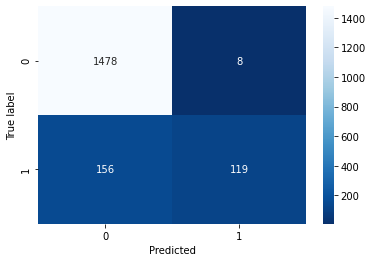

In [55]:
y_test_pred = CB_CV.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

- У полученной модель довольно высокая точность (Accuracy), что означает, что она хорошо предсказывает в общем случае. 
- Однако показатель Recall для класса 1 довольно низкая, что указывает на то, что модель пропускает много объектов класса 1 и предсказывает их как класс 0. Это не очень хорошо с точки зрения бизнеса, но в целом показатели довольно точные в большинстве случаев.

Количество правильных ответов модели значительно преобладает над ошибочными: 1478 True Negative, 156 True Positive.

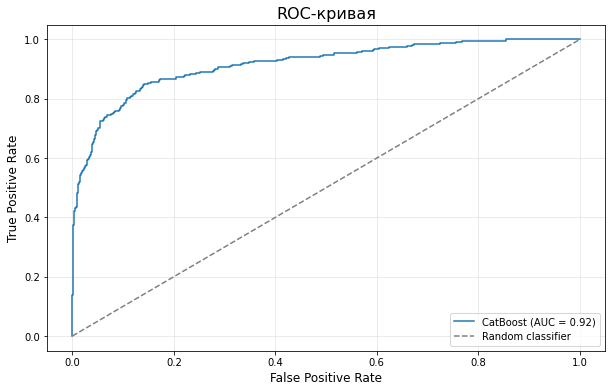

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))

RocCurveDisplay.from_estimator(
    CB_CV,           
    X_test,          
    y_test,          
    ax=ax,
    name='CatBoost'  
)

ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random classifier')

ax.set_title('ROC-кривая', fontsize=16)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.show()

Визуализируем, какие признаки больше всего повлияли на предсказание.

In [57]:
X_train.columns

Index(['PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Partner',
       'MultipleLines', 'period'],
      dtype='object')

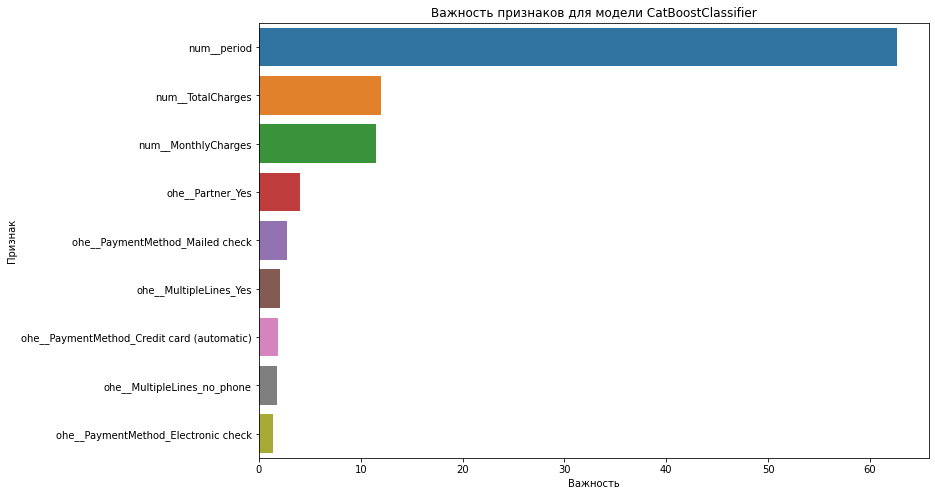

In [58]:
best_model = CB_CV.best_estimator_
model = best_model.named_steps['model']

# Получение важности признаков и их имен
feature_importances = model.get_feature_importance()

# Извлекаем шаги пайплайна с названиями признаков
data_preprocessor = best_model.named_steps['scaler']

# Получаем имена признаков после всех преобразований
transformed_feature_names = data_preprocessor.get_feature_names_out()

# Создание датафрейма для удобного отображения
feature_importance_df = pd.DataFrame({
    'Признак': transformed_feature_names,
    'Важность': feature_importances
})

# Сортировка по важности признаков
feature_importance_df = feature_importance_df.sort_values(by='Важность', ascending=False)

# Построение графика
plt.figure(figsize=(12, 8))
sns.barplot(x='Важность', y='Признак', data=feature_importance_df)
plt.title('Важность признаков для модели CatBoostClassifier')
plt.show()

На графике можно наглядно увидеть, что самые важные признаки которые повлияли на предсказание результата это:

- period - время, которое прошло с даты заключения договора
- TotalCharges - общие расходы абонента за все время
- MonthlyCharges - размер ежемесячного платежа абонента
- Partner - наличие супруга(и) у абонента

Эти признаки заметно самые весомые и важные из всех остальных. Веса остальных признаков находятся примерно на одном уровне. 

## Итоговый вывод

**Выводы по загрузке данных**

- Данные были загружены и проверены на соответствие
- Некоторые числа и даты записаны типом object (требуется заменить)
- Булевые переменные обозначены словами (не требует изменений)
- Отсутствуют пропуски в данных
- Отсутствует столбец с целевым признаком (требуется создать) 

**Выводы по предобработке данных**

- Числа и даты были переведены в нужный тип данных
- Создан столбец с целевым признаком
- Дубликаты не обнаружены
- Опечатки не обнаружены

**Выводы по исследовательскому анализу данных**

- В данных выбросов не обнаружено.
- Месячные оплаты распределены таким образом, что основная часть пользователей платят 20 долларов, видимо, это цена минимальной подписки.
- Дальше помесячная оплата распределена более равномерно с пиками сумм 50, 60, 70, 80, 90, 100 и 110 долларов.
- В гистограмме **period** мы видим, что новых пользователей, которые пользуются подпиской первый год, больше. Однако есть и достаточно большое количесво пользователей, которые пользуются подпиской более 5 с половиной лет.
- Чуть больше половины пользователей предпочитаю **помесячную оплату** подписки.
- У 21% пользователей не подключена дополнительная услуга интернета.
- Количество пользователей мужчин и женщин практически одинаковое. 
- 16% пользователей - это жители пенсионного возраста.
- **15% процентов пользователей не продлили подписку**.

Наибольшие корреляционные значения показывают:
- сроки использования подписки - **period**.
- сколько клиент потратил на подписку - **TotalCharges**.

Чем дольше клиент пользуется подпиской и чем больше он заплатил за всё время, тем меньше вероятность, что клиент откажется от продления подписки.

**Подготовка и обучение модели**

В ходе подготовки и обучения использовались модели: DecisionTreeClassifier, SVC, LogisticRegression, CatBoostClassifier.

Лучше всех себя показала модель **CatBoostClassifier** с гиперпараметрами **('model__depth': 5, 'model__learning_rate': 0.03)**. Её метрика **roc_auc** на тренировочной выборке составила **0.85**. А на тестовой - **0.91**.
- У полученной модель довольно высокая точность (Accuracy), что означает, что она хорошо предсказывает в общем случае. 
- Однако показатель Recall для класса 1 довольно низкая, что указывает на то, что модель пропускает много объектов класса 1 и предсказывает их как класс 0. Это не очень хорошо с точки зрения бизнеса, но в целом показатели довольно точные в большинстве случаев.

Количество правильных ответов модели значительно преобладает над ошибочными: 1478 True Negative, 156 True Positive.

Самые важные признаки которые повлияли на предсказание результата это:

- period - время, которое прошло с даты заключения договора
- TotalCharges - общие расходы абонента за все время
- MonthlyCharges - размер ежемесячного платежа абонента
- Partner - наличие супруга(и) у абонента

**Рекомендации для бизнеса**

На основе проведенного анализа данных и построенной модели прогнозирования оттока клиентов, можно порекомендовать следующее:

*Фокус на лояльность долгосрочных клиентов*

- Разработать программу лояльности для клиентов со стажем более 5 лет
- Предложить эксклюзивные условия и бонусы для данной категории

*Удержания новых клиентов*

- Усилить поддержку клиентов в первый год использования услуги

*Улучшение сервиса для семейных клиентов*

- Разработать семейные пакеты и акции, так как наличие партнера является важным фактором лояльности